## 라이브러리 및 데이터 불러오기

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from sklearn import model_selection

In [7]:
df = pd.read_csv('train.csv')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
# numerical data: 'age', 'height', 'weight', 'ap_hi', 'ap_lo'

# categorical data: 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'

# target data: 'cardio'

## Train, Validation, Test split

In [12]:
# target value 분류
target = df[['cardio']]
train = df[df.columns[1:-1]]

In [15]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(train, target, test_size=0.2, random_state=42)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(54811, 11) (54811, 1) (13703, 11) (13703, 1)


In [16]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train, target, test_size=0.2, random_state=42)

print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape)

(54811, 11) (54811, 1) (13703, 11) (13703, 1) (13703, 11) (13703, 1)


## Keras Logit 모델 fitting

In [53]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(11,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# CallBack 함수를 통해 LR을 낮출 것이므로, 초기 LR을 높게 잡기
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 256)               3072      
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 69,121
Trainable params: 69,121
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Call-back 함수
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='Models/{epoch:03d}-{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}.hdf5',
            monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#minitor -> loss -> val_loss

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=4,
                       verbose=1, min_lr=1e-8)
# factor: Learning rate에 곱할 것.
#0.1 -> 0.08 -> 0.064 ....
#monitor='loss' -> monitor='val_loss'

CALLBACK = [CP, LR]

In [ ]:
# case1_Best model
# 256, 256, elu
# history = model.fit(x=train_x, y=train_y, epochs=100, shuffle=True, batch_size=32, 
                    # callbacks=CALLBACK, validation_data=(valid_x, valid_y))

In [ ]:
# case2
# 5 10 linear
# model.fit(x=train_x, y=train_y, epochs=200, shuffle=True, batch_size=32, 
#           callbacks=CALLBACK, validation_data=(valid_x, valid_y))

In [ ]:
# case3
#2, 512, elu
# history = model.fit(x=train_x, y=train_y, epochs=200, shuffle=True, batch_size=32, 
#                     callbacks=CALLBACK, validation_data=(valid_x, valid_y))

In [60]:
model.load_weights('./Models/063-0.5416-0.7331-0.5433.hdf5')

## 성능 확인

In [ ]:
# case1
result = model.evaluate(test_x, test_y)

print('loss(cross_entropy): ', result[0])
print('test accuracy: ', result[1])

429/429 [==============================] - 1s 2ms/step - loss: 0.5433 - accuracy: 0.7331
loss(cross_entropy):  0.5433281660079956
test accuracy:  0.7331241369247437


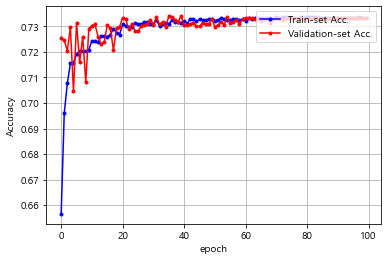

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

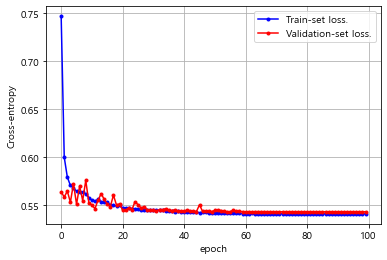

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

In [61]:
import scikitplot as skplt
from sklearn.metrics import roc_auc_score

In [62]:
print(roc_auc_score(valid_y, model.predict(valid_x)))

0.7154641137209299


In [63]:
from sklearn import metrics
# ROC curve 시각화
Label = valid_y
pred = model.predict(valid_x)
fpr, tpr, _ = metrics.roc_curve(Label,  pred)

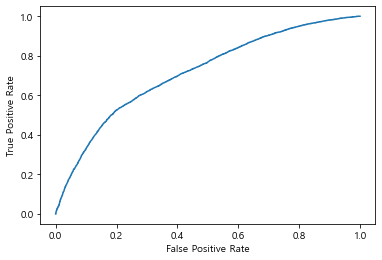

In [64]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

0.7158948262543964


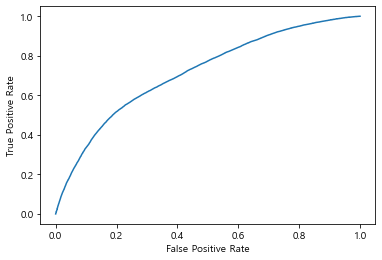

In [65]:
print(roc_auc_score(train_y, model.predict(train_x)))
# ROC curve 시각화
Label = train_y
pred = model.predict(train_x)
fpr, tpr, _ = metrics.roc_curve(Label,  pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()